# Sharpen with bilinear and sharp u net

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [9]:
from tensorflow.keras.layers import Input, Dense, ReLU, Add, Conv1D, BatchNormalization, LayerNormalization, Layer, Flatten, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, DepthwiseConv2D
from tensorflow.keras import losses
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from tensorflow.image import resize


### Set up for up and down scaling

In [3]:
def get_kernel():
    """
    See https://setosa.io/ev/image-kernels/
    """

    k1 = np.array([[0.0625, 0.125, 0.0625],
                   [0.125,  0.25, 0.125],
                   [0.0625, 0.125, 0.0625]])
    
    # Sharpening Spatial Kernel, used in paper
    k2 = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
    
    k3 = np.array([[0, -1, 0],
                   [-1,  5, -1],
                   [0, -1, 0]])
    
    return k1, k2, k3


def build_sharp_blocks(layer):
    """
    Sharp Blocks
    """
    # Get number of channels in the feature
    in_channels = layer.shape[-1]
    # Get kernel
    _, w, _ = get_kernel()    
    # Change dimension
    w = np.expand_dims(w, axis=-1)
    # Repeat filter by in_channels times to get (H, W, in_channels)
    w = np.repeat(w, in_channels, axis=-1)
    # Expand dimension
    w = np.expand_dims(w, axis=-1)
    return w

In [4]:
def SharpUNet(inputs, num_classes):
    "Unet with sharp Blocks in skip connections"

    # Kernel size for sharp blocks
    kernel_size = 3

    #inputs = Input(img_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    # Skip connection 1
    # 1. Get sharpening kernel weights(1, H, W, channels) 
    W1 = build_sharp_blocks(conv4)
    # 2. Build depthwise convolutional layer with random weights
    sb1 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    # 3. Pass input to layer
    conv4 = sb1(conv4)
    # 4. Set filters as layer weights 
    sb1.set_weights([W1])
    # 5. Dont update weights
    sb1.trainable = False
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    # Skip connection 2
    W2 = build_sharp_blocks(conv3) 
    sb2 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv3 = sb2(conv3)
    sb2.set_weights([W2])
    sb2.trainable = False
   
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Skip connection 3
    W3 = build_sharp_blocks(conv2) 
    sb3 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv2 = sb3(conv2)
    sb3.set_weights([W3])
    sb3.trainable = False
    
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    
    # Skip connection 4
    W4 = build_sharp_blocks(conv1)
    sb4 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv1 = sb4(conv1)
    sb4.set_weights([W4])
    sb4.trainable = False
    

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # for multi-class segmentation, use the 'softmax' activation
    #conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)
    
    #model = Model(inputs=[inputs], outputs=[conv10])    
    
    return conv9


In [5]:
def rationalConv(x, filters=16, kernel_size=(3,3), padding="same", start=7, end=3):
    """
    Where ordinary convolutions down-scale by an integer stride, 
    the rational version up-samples and down-scales an integer stride to 
    reach a desired rational upscaling.

    Example: 7 -> 3 => 7 * bilinear(9/7) = 9, 9 / conv(3) = 3
    """
    size = x.shape
    stride = np.ceil(start/end).astype(int)
    scaling = (end*stride)/start
    
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    if stride > 1:
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    return x

def rationalConvTransposed(x, filters=16, kernel_size=(3,3), padding="same", start=3, end=7):
    """
    Where ordinary transposed convolutions up-scale by an integer stride, 
    the rational version up-scales an integer stride and down-samples to 
    reach a desired rational upscaling.
    
    Example: 3 -> 7 => 3 * convTr(3) = 9, 9 * bilinear(7/9) = 7
    """
    size = x.shape
    stride = np.ceil(end/start).astype(int)
    scaling = end/start
    
    if stride > 1:
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    return x


In [13]:

input_img = Input(shape=(55,55,3))

x = rationalConvTransposed(input_img, filters=3,end=7, start=3)
x = Conv2D(3, kernel_size=3, padding="same", activation='linear')(x)
x = SharpUNet(x, num_classes=1)

x = Conv2D(3, kernel_size=1, padding="same", activation='linear')(x)

model = Model(inputs = [input_img], outputs = [x])
model.compile(optimizer='adam',
              loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 55, 55, 3)]  0           []                               
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 165, 165, 3)  84         ['input_1[0][0]']                
 ose)                                                                                             
                                                                                                  
 tf.image.resize (TFOpLambda)   (None, 128, 128, 3)  0           ['conv2d_transpose[0][0]']       
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 3)  84          ['tf.image.resize[0][0]']    

## Load data - show data

In [7]:
X = np.load("sharpen/X_data.npy")
y = np.load("sharpen/y_data.npy")

X = X[:,:,:,:]
y = y[:,:,:,:]

print(X.shape)
print(y.shape)

(50, 55, 55, 3)
(50, 128, 128, 3)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(40, 55, 55, 3)
(10, 55, 55, 3)


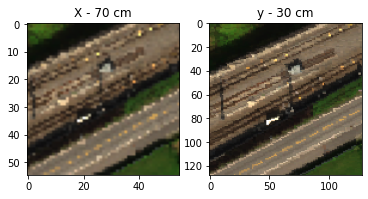

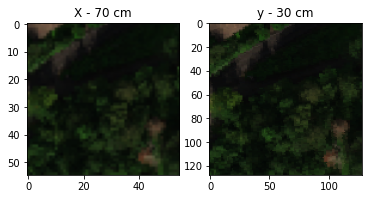

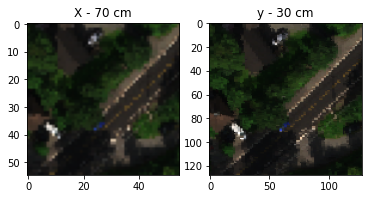

In [8]:
indx = np.random.randint(0,high=X.shape[0],size=3)
for i in range(3):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
  ax1.imshow(X[indx[i]]); ax1.set_title("X - 70 cm")
  ax2.imshow(y[indx[i]]); ax2.set_title("y - 30 cm")
  plt.show()

In [ ]:
y.shape # small cahng

(50, 128, 128, 3)

In [14]:
h = model.fit(X_train,y_train,
              validation_data=(X_test,y_test),
              batch_size=10,
              epochs=200)

Epoch 1/200
4/4 [==============================] - 15s 564ms/step - loss: 0.0562 - val_loss: 0.0456
Epoch 2/200
4/4 [==============================] - 0s 53ms/step - loss: 0.0317 - val_loss: 0.0196
Epoch 3/200
4/4 [==============================] - 0s 51ms/step - loss: 0.0150 - val_loss: 0.0120
Epoch 4/200
4/4 [==============================] - 0s 52ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 5/200
4/4 [==============================] - 0s 53ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 6/200
4/4 [==============================] - 0s 55ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 7/200
4/4 [==============================] - 0s 54ms/step - loss: 0.0084 - val_loss: 0.0090
Epoch 8/200
4/4 [==============================] - 0s 53ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 9/200
4/4 [==============================] - 0s 52ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 10/200
4/4 [==============================] - 0s 49ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 11/200
4/4 

Text(0, 0.5, 'loss mse')

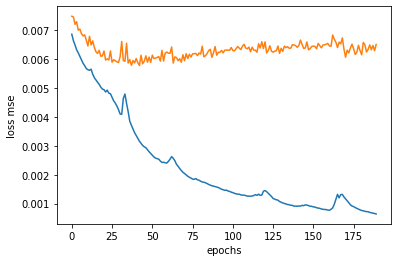

In [18]:
plt.plot(h.history['loss'][10:])
plt.plot(h.history['val_loss'][10:])
plt.xlabel("epochs"); plt.ylabel("loss mse")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


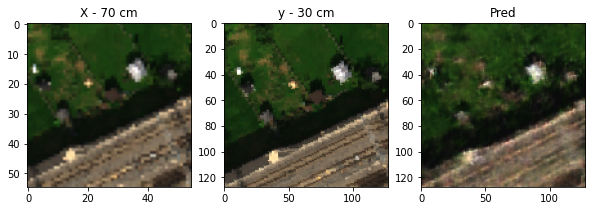

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


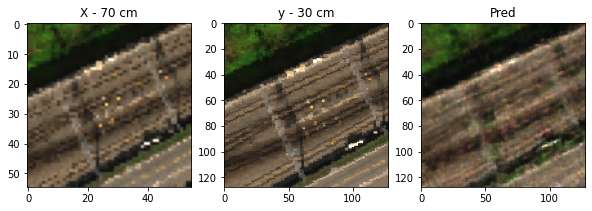

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


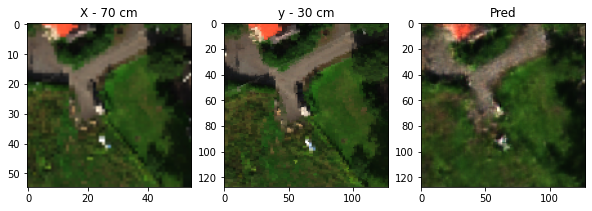

In [17]:
indx = np.random.randint(0,high=X_test.shape[0],size=3)
for i in range(3):
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
  pred = model.predict(X_test[indx[i]:indx[i]+1])[0]
  ax1.imshow(X_test[indx[i]]); ax1.set_title("X - 70 cm")
  ax2.imshow(y_test[indx[i]]); ax2.set_title("y - 30 cm")
  ax3.imshow(pred[:,:,:]); ax3.set_title("Pred")
  plt.show()


In [ ]:
sample_model = Model(inputs=model.input, outputs=[model.layers[2].output])

In [ ]:
sample_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 55, 55, 3)]       0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 165, 165, 3)      84        
 Transpose)                                                      
                                                                 
 tf.image.resize_5 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


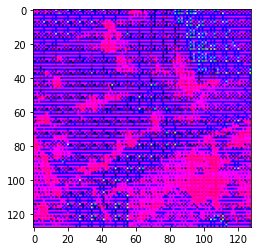

In [ ]:
plt.imshow(sample_model.predict(X[4:5])[0]*100)

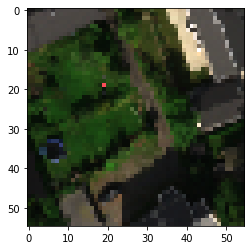

In [ ]:
plt.imshow(X[4:5][0])